In [1]:
import PythonicDISORT
from PythonicDISORT.subroutines import _compare
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from math import pi

Previously saved reference solutions will be loaded if F2PY-wrapped Stamnes' DISORT is unavailable.

In [2]:
disort_is_installed = True
try:
    import disort
    print("Stamnes' DISORT imported.")
except ImportError:
    disort_is_installed = False
    print("Stamnes' DISORT unavailable. Cached results will be used.")

# Table of Contents
* [2a and setup](#2a-and-setup)
* [2b](#2b)
* [2c](#2c)
* [2d](#2d)


# Test Problem 2:  Rayleigh Scattering, Beam Source

The *Rayleigh phase function* is appropriate when the wavelength of the radiation is much larger than the scattering particles (note that PythonicDISORT, like DISORT, assumes the scattering particles to be spheres, at least when averaged over their orientations). Rayleigh scattering is most well-known for explaining the blue color of a clear sky and the phase function is most commonly used to model clear sky radiative transfer. Consequently it should be paired with thin atmospheres (small `tau_arr`), though the test problems are not intended to serve as realistic models. The Rayleigh phase function is often described as "isotropic" and its asymmetry parameter or expected value $g = 0$ but it should not be confused with the isotropic phase function.

Results can be compared to Table 1 of Sweigart, A., 1970: Radiative Transfer in Atmospheres Scattering According to the Rayleigh Phase Function with Absorption, *The Astrophysical Journal Supplement Series* 22, 1-80. The intensity field of the upwelling radiation, which can be compared to satellite measurements, is plotted for each subproblem.

# 2a and setup

**PythonicDISORT**

In [3]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 0.2  # One layer of thickness 0.2 (thin atmosphere)
omega_arr = 0.5  # 50% of light is scattered each interaction (highly absorbing medium)
NQuad = 16  # 16 streams (8 quadrature nodes for each hemisphere)
Leg_coeffs_all = np.zeros(17)
Leg_coeffs_all[0] = 1
Leg_coeffs_all[2] = 0.1  # Rayleigh phase function
mu0 = 0.080442  # Cosine of solar zenith angle (low, glancing angle)
I0 = pi  # Intensity of direct beam
phi0 = pi  # Azimuthal angle of direct beam

# Optional (used)

# Optional (unused)
NLeg = None
NFourier = None
b_pos = 0
b_neg = 0
only_flux = False
f_arr = 0
NT_cor = False
BDRF_Fourier_modes = []
s_poly_coeffs = np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [4]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
)

**Setup for tests**

In [5]:
# Reorder mu_arr from smallest to largest
reorder_mu = np.argsort(mu_arr)
mu_arr_RO = mu_arr[reorder_mu]

# We may not want to compare intensities around the direct beam
deg_around_beam_to_not_compare = 0
mu_to_compare = (
    np.abs(np.arccos(np.abs(mu_arr_RO)) - np.arccos(mu0)) * 180 / pi
    > deg_around_beam_to_not_compare
)
mu_test_arr_RO = mu_arr_RO[mu_to_compare]

In [6]:
# Number of phi grid points
Nphi = 2
phi_arr = np.random.random(Nphi) * 2 * pi

# tau test points
tau_test_arr = np.array([0, 0.2])
Ntau = len(tau_test_arr)

**Stamnes' DISORT**

In [7]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: NQuad + 1]
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [8]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    # Load saved results from Stamnes' DISORT
    results = np.load("Stamnes_results/2a_test.npz")

**Comparisons**

In [9]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 2.743420303430444e-09
Difference ratio = 5.1272885847482005e-08

Downward (diffuse) fluxes
Difference = 3.807660589605355e-09
Difference ratio = 8.618695600726441e-08

Direct (downward) fluxes
Difference = 8.608410095867214e-09
Difference ratio = 7.857562845581812e-08

Intensities

At tau = 0.0
Max pointwise difference = 3.214948962604325e-08
At tau = 0.2
Max pointwise difference ratio = 4.78059745709299e-07



**Does the test pass?**

In [10]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/2a_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [11]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

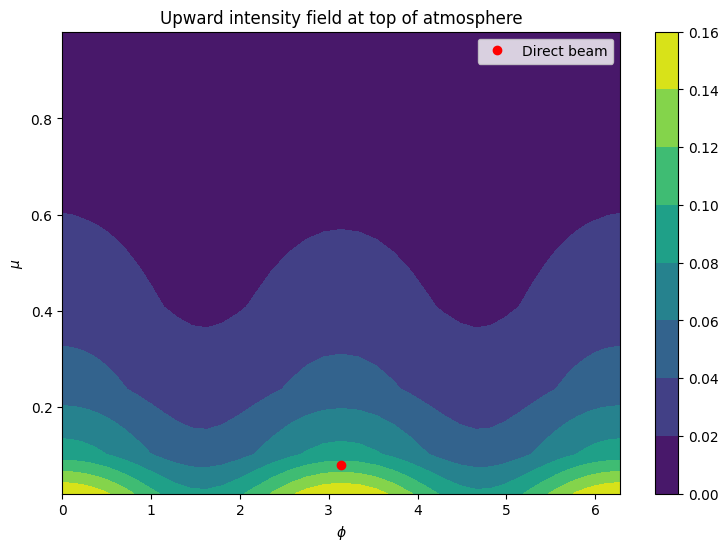

In [12]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

----------

# 2b

**PythonicDISORT**

In [13]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 0.2
omega_arr = 1 - 1e-6  # Reduced from 1 (conservative scattering) which is not implemented
NQuad = 16
Leg_coeffs_all = np.zeros(17)
Leg_coeffs_all[0] = 1
Leg_coeffs_all[2] = 0.1
mu0 = 0.080442
I0 = pi
phi0 = pi

# Optional (used)

# Optional (unused)
NLeg=None
NFourier=None
b_pos=0
b_neg=0
only_flux=False
f_arr=0
NT_cor=False
BDRF_Fourier_modes=[]
s_poly_coeffs=np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [14]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
)

**Stamnes' DISORT**

In [15]:
# tau test points
tau_test_arr = np.array([0, 0.2])
Ntau = len(tau_test_arr)

In [16]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: NQuad + 1]
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [17]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    # Load saved results from Stamnes' DISORT
    results = np.load("Stamnes_results/2b_test.npz")

**Comparisons**

In [18]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 2.5980007460624233e-06
Difference ratio = 2.06915273660889e-05

Downward (diffuse) fluxes
Difference = 3.7252903030397413e-06
Difference ratio = 1.525515277237756e-05

Direct (downward) fluxes
Difference = 8.608410095867214e-09
Difference ratio = 7.857562845581812e-08

Intensities

At tau = 0.0
Max pointwise difference = 1.9168894213605903e-06
At tau = 0.0
Max pointwise difference ratio = 3.370614402249061e-05



**Does the test pass?**

In [19]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/2b_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [20]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

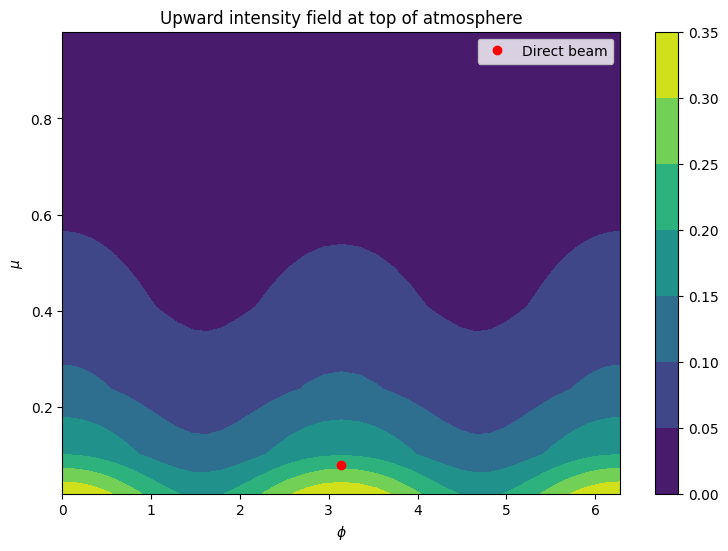

In [21]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

-------

# 2c

**PythonicDISORT**

In [22]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 5
omega_arr = 0.5
NQuad = 16
Leg_coeffs_all = np.zeros(17)
Leg_coeffs_all[0] = 1
Leg_coeffs_all[2] = 0.1
mu0 = 0.080442
I0 = pi
phi0 = pi

# Optional (used)

# Optional (unused)
NLeg=None
NFourier=None
b_pos=0
b_neg=0
only_flux=False
f_arr=0
NT_cor=False
BDRF_Fourier_modes=[]
s_poly_coeffs=np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [23]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
)

**Stamnes' DISORT**

In [24]:
# tau test points
tau_test_arr = np.array([0, 5])
Ntau = len(tau_test_arr)

In [25]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: NQuad + 1]
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [26]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    # Load saved results from Stamnes' DISORT
    results = np.load("Stamnes_results/2c_test.npz")

**Comparisons**

In [27]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 1.0912541564822575e-09
Difference ratio = 1.7467624222722225e-08

Downward (diffuse) fluxes
Difference = 6.740847425601784e-11
Difference ratio = 2.678304890047816e-07

Direct (downward) fluxes
Difference = 8.608410095867214e-09
Difference ratio = 3.406357306506376e-08

Intensities

At tau = 0
Max pointwise difference = 1.0796764968179495e-08
At tau = 0
Max pointwise difference ratio = 3.824424670469725e-07



**Does the test pass?**

In [28]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/2c_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [29]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

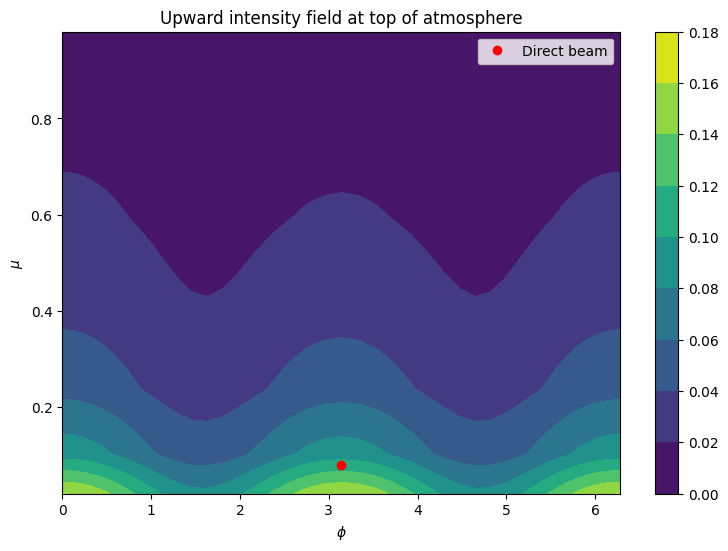

In [30]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

-------

# 2d

**PythonicDISORT**

In [31]:
######################################### PYDISORT ARGUMENTS #######################################

tau_arr = 5
omega_arr = 1 - 1e-6  # Reduced from 1 (conservative scattering) which is not implemented
NQuad = 16
Leg_coeffs_all = np.zeros(17)
Leg_coeffs_all[0] = 1
Leg_coeffs_all[2] = 0.1
mu0 = 0.080442
I0 = pi
phi0 = pi

# Optional (used)

# Optional (unused)
NLeg=None
NFourier=None
b_pos=0
b_neg=0
only_flux=False
f_arr=0
NT_cor=False
BDRF_Fourier_modes=[]
s_poly_coeffs=np.array([[]])
use_banded_solver_NLayers=10
autograd_compatible=False

####################################################################################################

In [32]:
# Call pydisort function
mu_arr, flux_up, flux_down, u0, u = PythonicDISORT.pydisort(
    tau_arr, omega_arr,
    NQuad,
    Leg_coeffs_all,
    mu0, I0, phi0,
)

**Stamnes' DISORT**

In [33]:
# tau test points
tau_test_arr = np.array([0, 5])
Ntau = len(tau_test_arr)

In [34]:
# Stamnes' DISORT arguments
nlyr = 1
nmom = NQuad
nstr = NQuad
numu = NQuad
nphi = Nphi
ntau = Ntau
usrang = True
usrtau = True
ibcnd = 0
onlyfl = False
prnt = np.array([False, False, False, False, False])  # Prints to CMD instead of this notebook
plank = False
lamber = True
deltamplus = False
do_pseudo_sphere = False
dtauc = tau_arr
ssalb = omega_arr
pmom = Leg_coeffs_all.T[: NQuad + 1]
temper = np.zeros(nlyr + 1)
wvnmlo = 0
wvnmhi = 0
utau = tau_test_arr
umu0 = mu0
phi0 = phi0
umu = mu_arr_RO
phi = phi_arr
fbeam = I0
fisot = 0
albedo = 0
btemp = 0
ttemp = 0
temis = 0
earth_radius = 6371
h_lyr = np.zeros(nlyr + 1)
rhoq = np.zeros((nstr // 2, nstr + 1, nstr))
rhou = np.zeros((numu, nstr // 2 + 1, nstr))
rho_accurate = np.zeros((numu, nphi))
bemst = np.zeros(nstr // 2)
emust = np.zeros(numu)
accur = 0
header = ""
rfldir = np.zeros(ntau)
rfldn = np.zeros(ntau)
flup = np.zeros(ntau)
dfdt = np.zeros(ntau)
uavg = np.zeros(ntau)
uu = np.zeros((numu, ntau, nphi))
albmed = np.zeros(numu)
trnmed = np.zeros(numu)

In [35]:
if disort_is_installed:
    # Run disort, putting DFDT, UAVG, and UU in a, b, and c, respectively
    rfldir, rfldn, flup, dfdt, uavg, uu, albmed, trnmed = disort.disort(usrang, usrtau, ibcnd, onlyfl, prnt, plank, lamber, deltamplus, do_pseudo_sphere, dtauc, ssalb,
                            pmom, temper, wvnmlo, wvnmhi, utau, umu0, phi0 * 180/pi, umu, phi * 180/pi, fbeam, fisot, albedo, btemp, ttemp,
                            temis, earth_radius, h_lyr, rhoq, rhou, rho_accurate, bemst, emust, accur, header, rfldir,
                            rfldn, flup, dfdt, uavg, uu, albmed, trnmed)
    results = {
        "uu": uu,
        "flup": flup,
        "rfldn": rfldn,
        "rfldir": rfldir,
        "tau_test_arr": tau_test_arr,
        "phi_arr": phi_arr
    }
else:
    # Load saved results from Stamnes' DISORT
    results = np.load("Stamnes_results/2d_test.npz")

**Comparisons**

In [36]:
(
    diff_flux_up,
    ratio_flux_up,
    diff_flux_down_diffuse,
    ratio_flux_down_diffuse,
    diff_flux_down_direct,
    ratio_flux_down_direct,
    diff,
    diff_ratio,
) = _compare(results, mu_to_compare, reorder_mu, flux_up, flux_down, u)

Max pointwise differences

Upward (diffuse) fluxes
Difference = 4.447920235185081e-07
Difference ratio = 1.7692472235396034e-06

Downward (diffuse) fluxes
Difference = 2.7969285355811113e-07
Difference ratio = 0.9999999882966554

Direct (downward) fluxes
Difference = 8.608410095867214e-09
Difference ratio = 3.406357306506376e-08

Intensities

At tau = 5
Max pointwise difference = 1.9502568557750594e-07
At tau = 5
Max pointwise difference ratio = 2.873582260466984e-05



**Does the test pass?**

In [37]:
assert np.max(ratio_flux_up[diff_flux_up > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_diffuse[diff_flux_down_diffuse > 1e-3], initial=0) < 1e-3
assert np.max(ratio_flux_down_direct[diff_flux_down_direct > 1e-3], initial=0) < 1e-3
assert np.max(diff_ratio[diff > 1e-3], initial=0) < 1e-2

'''np.savez_compressed (
    "Stamnes_results/2d_test",
    phi_arr=phi_arr,
    tau_test_arr=tau_test_arr,
    uu=uu,
    flup=flup,
    rfldn=rfldn,
    rfldir=rfldir,
)'''

print("The test passes")

The test passes


**Plots**

In [38]:
Nphi_plot = int((NQuad * pi) // 2) * 2 + 1
phi_arr_plot, full_weights_phi = PythonicDISORT.subroutines.Clenshaw_Curtis_quad(Nphi_plot)

MU_ARR, PHI_ARR = np.meshgrid(phi_arr_plot, mu_arr[:NQuad // 2])

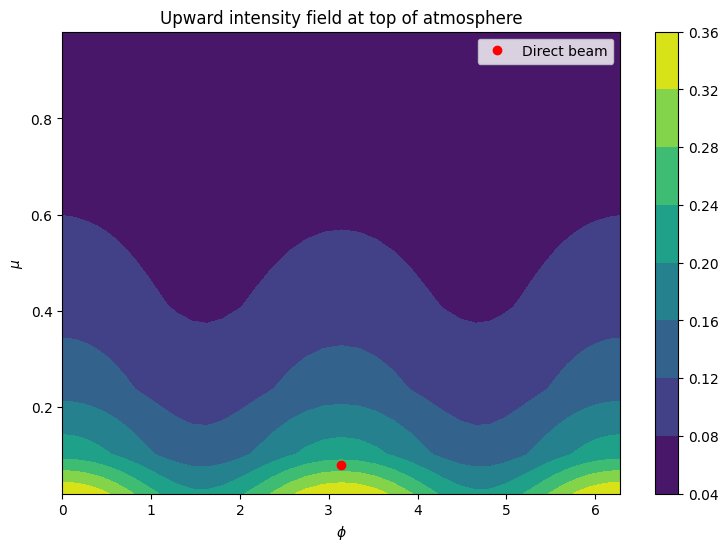

In [39]:
plot = u(0, phi_arr_plot)[:NQuad // 2]

fig = plt.figure(figsize=(9, 6))
_contourf = plt.contourf(MU_ARR, PHI_ARR, plot)
plt.plot(phi0, mu0, "o", color="red", label="Direct beam")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\mu$")
plt.colorbar(_contourf)
plt.title(
    "Upward intensity field at top of atmosphere"
)
plt.legend()

-------